# **Emotional TTS System**
*In this part, we will build our own emotional TTS system! The TTS will speak with our very own voice.
Therefore, we will use Voice Cloning. At the end, we will have a little system that we can feed with text and a target emotion, producing emotional speech audio resembling our own voice.*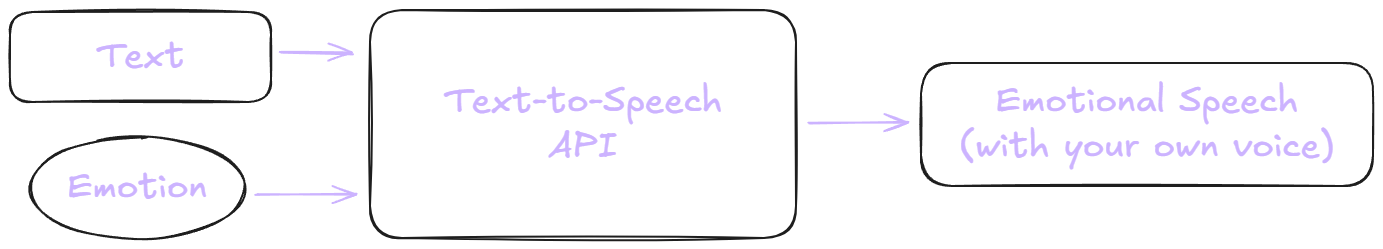

*Cloning a voice commonly works by parametrizing an appropriate TTS model with a reference audio sample. The model then infers all voice characteristics from that sample. However, those voice characteristics do not only include the speaker's voice characteristics, but also the prosody of the reference sample.*

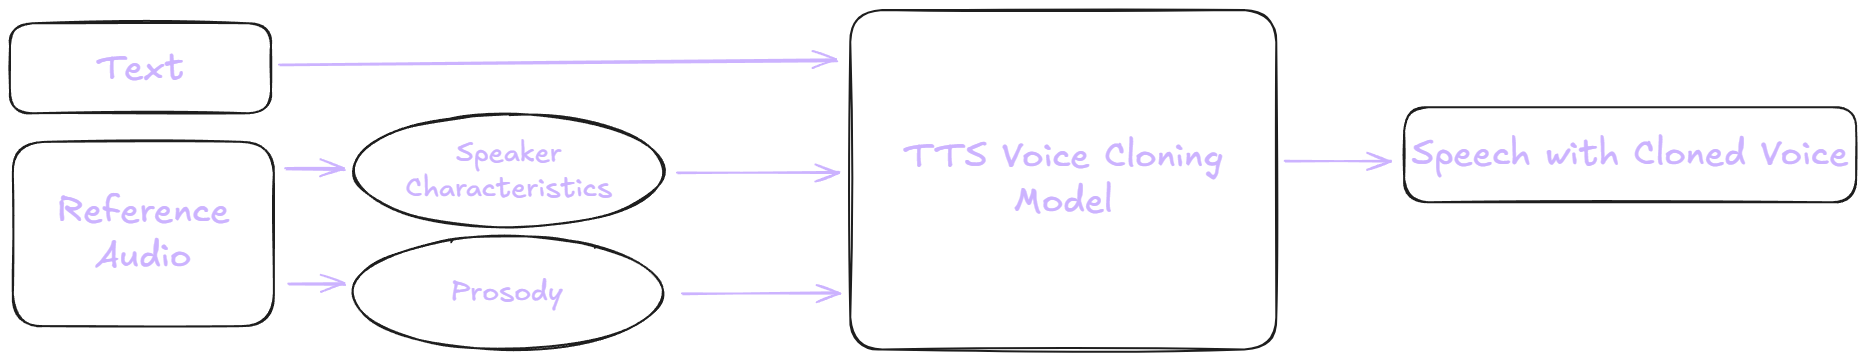



*As such, using different reference samples from the same speaker (you), but spoken with different emotions, we can simulate an emotional TTS model. In other words, we keep the speaker characteristics fixed and only vary the prosody, resulting in different emotions:*

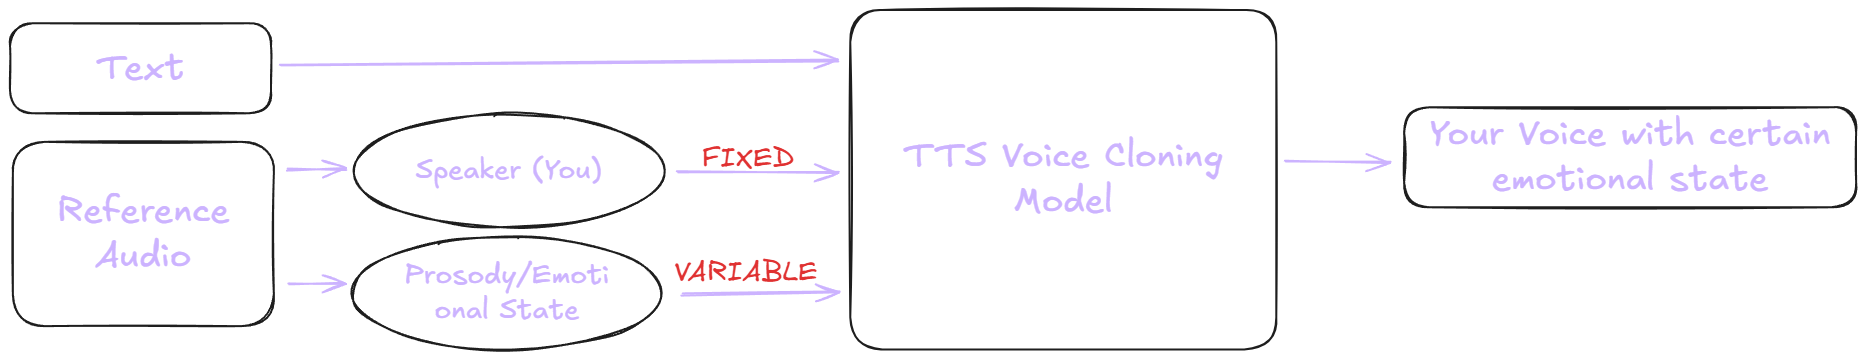


*We will record and label a variety of voice samples from our own voice. Those samples should cover a substantial part of the emotional space. In this Jupyter Notebook, we walk you through the process of setting up your own emotional TTS.*

# Create Python Environment
Execute the following cells to setup the Python environment. By doing so, all necessary packages will be installed, the file structure is initialized, and needed resources are downloaded.

In [7]:
!mkdir ReferenceAudio
!gdown 1RfqxcWBgU6yGdY4n6Vhz0w0BJp-iiM6w

mkdir: cannot create directory ‘ReferenceAudio’: File exists
Downloading...
From: https://drive.google.com/uc?id=1RfqxcWBgU6yGdY4n6Vhz0w0BJp-iiM6w
To: /content/va_space.png
100% 1.19M/1.19M [00:00<00:00, 102MB/s]


**Note:** If you get an error about pip's dependency resolver while executing the following command, just ignore it ;-)

In [8]:
!pip install TTS

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.9 MB/s eta 0:00:00
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 1.5.3 which is incompatible.
scikit-image 0.25.2 requires networkx>=3.0, but you have networkx 2.8.8 which is incompatible.
cudf-cu12 25.2.1 requires pandas<2.2.4dev0,>=2.0, but you have pandas 1.5.3 which is incompatible.
mizani 0.13.3 requires pandas>=2.2.0, but you have pandas 1.5.3 which is incompatible.
dask-cudf-cu12 25.2.2 

**Note:** After executing the following lines, you might have to restart your runtime. Also, it might be the case that you get some errors or warnings - just ignore them ;-)

In [9]:
!pip uninstall -y numpy
!pip install numpy==1.23.5


Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tts 0.22.0 requires numpy>=1.24.3; python_version > "3.10", but you have numpy 1.23.5 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 1.5.3 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.23.5 which is incompatible.
chex 0.1.89 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
scikit-image 0.25.2 requires networkx>=3.0, but you have networkx 2.8.8 which is incompatible.
scikit-image 0.25.2 requires numpy>=1

# Import Libraries
The needed python modules are loaded.
Among other libraries, we will use Coqui TTS for the voice cloning.

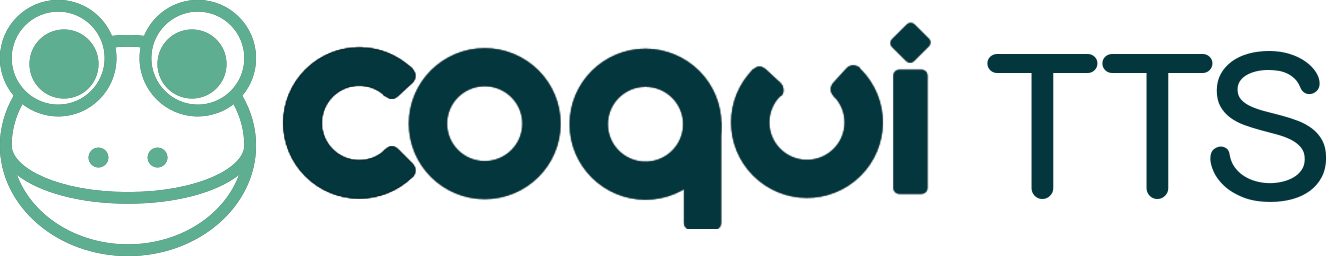

In [1]:
from TTS.api import TTS
import IPython.display as ipd
from google.colab import files
from IPython.display import Audio
import os
import re
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
from IPython.display import Audio
import tempfile



# Initialize the Text-To-Speech Model
By executing the following line, we initialize the TTS model. We will use "YourTTS", as it allows to be parametrized by only one reference audio sample.

In [2]:
tts = TTS(model_name="tts_models/multilingual/multi-dataset/your_tts")


 > tts_models/multilingual/multi-dataset/your_tts is already downloaded.
 > Using model: vits
 > Setting up Audio Processor...
 | > sample_rate:16000
 | > resample:False
 | > num_mels:80
 | > log_func:np.log10
 | > min_level_db:0
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:None
 | > fft_size:1024
 | > power:None
 | > preemphasis:0.0
 | > griffin_lim_iters:None
 | > signal_norm:None
 | > symmetric_norm:None
 | > mel_fmin:0
 | > mel_fmax:None
 | > pitch_fmin:None
 | > pitch_fmax:None
 | > spec_gain:20.0
 | > stft_pad_mode:reflect
 | > max_norm:1.0
 | > clip_norm:True
 | > do_trim_silence:False
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:False
 | > db_level:None
 | > stats_path:None
 | > base:10
 | > hop_length:256
 | > win_length:1024
 > Model fully restored. 
 > Setting up Audio Processor...
 | > sample_rate:16000
 | > resample:False
 | > num_mels:64
 | > log_func:np.log10
 | > min_level_db:-

# Define Python Methods
In the following cells, all necessary Python methods will be defined.

We will use a bunch of audio reference samples. Each sample represents one specific valence/arousal instance. The following method looks for all reference samples that we have and returns which valence/arousal pairs are covered.

In [3]:
def get_valence_arousal_pairs(directory="ReferenceAudio"):
    pattern = re.compile(r"Reference_v(-?\d+(?:\.\d+)?)_a(-?\d+(?:\.\d+)?)\.wav")
    va_dict = {}

    for filename in os.listdir(directory):
        match = pattern.match(filename)
        if match:
            valence = float(match.group(1))
            arousal = float(match.group(2))
            va_dict[(valence, arousal)] = os.path.join(directory, filename)

    return va_dict

The following method enables us to visualize our covered valence/arousal space. For each reference audio sample that we have uploaded, it marks the respective points in the valence/arousal space.

In [4]:
%matplotlib inline
def plot_va_points_on_image(image_path='va_space.png', audio_dir='ReferenceAudio'):
    # Load the image
    img = mpimg.imread(image_path)
    height, width = img.shape[:2]

    # Get VA coordinates from audio filenames
    va_dict = get_valence_arousal_pairs(audio_dir)

    # Set up the plot
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(img)

    # Set coordinate limits assuming valence/arousal range is -1 to 1
    ax.set_xlim(0, width)
    ax.set_ylim(height, 0)  # Flip Y axis so origin is in center

    # Draw each point
    for (valence, arousal) in va_dict:
        x = (valence + 1) / 2 * width    # map from [-1,1] to [0,width]
        y = (1 - (arousal + 1) / 2) * height  # map from [-1,1] to [0,height] and flip Y
        ax.plot(x, y, marker='o', markersize=10, color=(0.8235, 0.7529, 1.0))  # red dot

    ax.set_title("Valence-Arousal Mapping")
    plt.axis('off')
    plt.show()

If we want to synthesize new audio later on, we want to use the reference sample that is the closest to our target emotional state. As such, we are simply looking for the reference sample that has the closest euclidean distance to our target valence/arousal state.

In [5]:
def get_closest_va_file(valence_target, arousal_target, audio_dir='ReferenceAudio'):
    va_dict = get_valence_arousal_pairs(audio_dir)

    if not va_dict:
        print("No valid VA audio files found.")
        return None

    closest_file = None
    closest_distance = float('inf')

    for (valence, arousal), filepath in va_dict.items():
        dist = math.sqrt((valence - valence_target) ** 2 + (arousal - arousal_target) ** 2)
        if dist < closest_distance:
            closest_distance = dist
            closest_file = filepath

    return closest_file

The following method takes our target valence, our target arousal, and the text that we want to synthesize. It then uses our method defined above to find the best reference audio. Then, it synthesizes a new utterance.

In [6]:
def synthesize(text, valence, arousal, output_path=None):
    # Find the closest reference file
    reference_wav = get_closest_va_file(valence, arousal)

    if reference_wav is None:
        print("No reference audio found.")
        return

    print(f"Using reference: {reference_wav}")

    # If no path given, create a temporary file
    if output_path is None:
        tmp_file = tempfile.NamedTemporaryFile(suffix=".wav", delete=False)
        output_path = tmp_file.name
        auto_play = True
    else:
        auto_play = False

    # Synthesize speech
    tts.tts_to_file(
        text=text,
        file_path=output_path,
        speaker_wav=reference_wav,
        language="en"
    )

    print(f"Synthesized speech saved to: {output_path}")

    if auto_play:
        return Audio(output_path)

## **Create Our Emotional Samples!**`
For the next step, we will need a recording software. If we are on Windows, we can use the built-in "Audio Recorder" - just make sure to set the output format to "wav". If you are on Linux or Mac, you could download Audacity ([Download Link](https://www.audacityteam.org/download/)) or another recording tool of your choice.
- Record short sentences with different emotions of your voice (~5 seconds). Start with 4 different samples. (If you work with Audacity, export the samples as .wav file)


For our emotional TTS, we will use the 'Valence/Arousal' space. There, valence refers to how positive or negative an emotion is, while arousal refers to the level of activation of the emotion. If we look at valence and arousal as it being a 2D space, we can visualize a mapping of valence/arousal pairs to discrete emotions like happy, angry, or sad. However, working with valence arousal enables to describe emotions in much more detail:

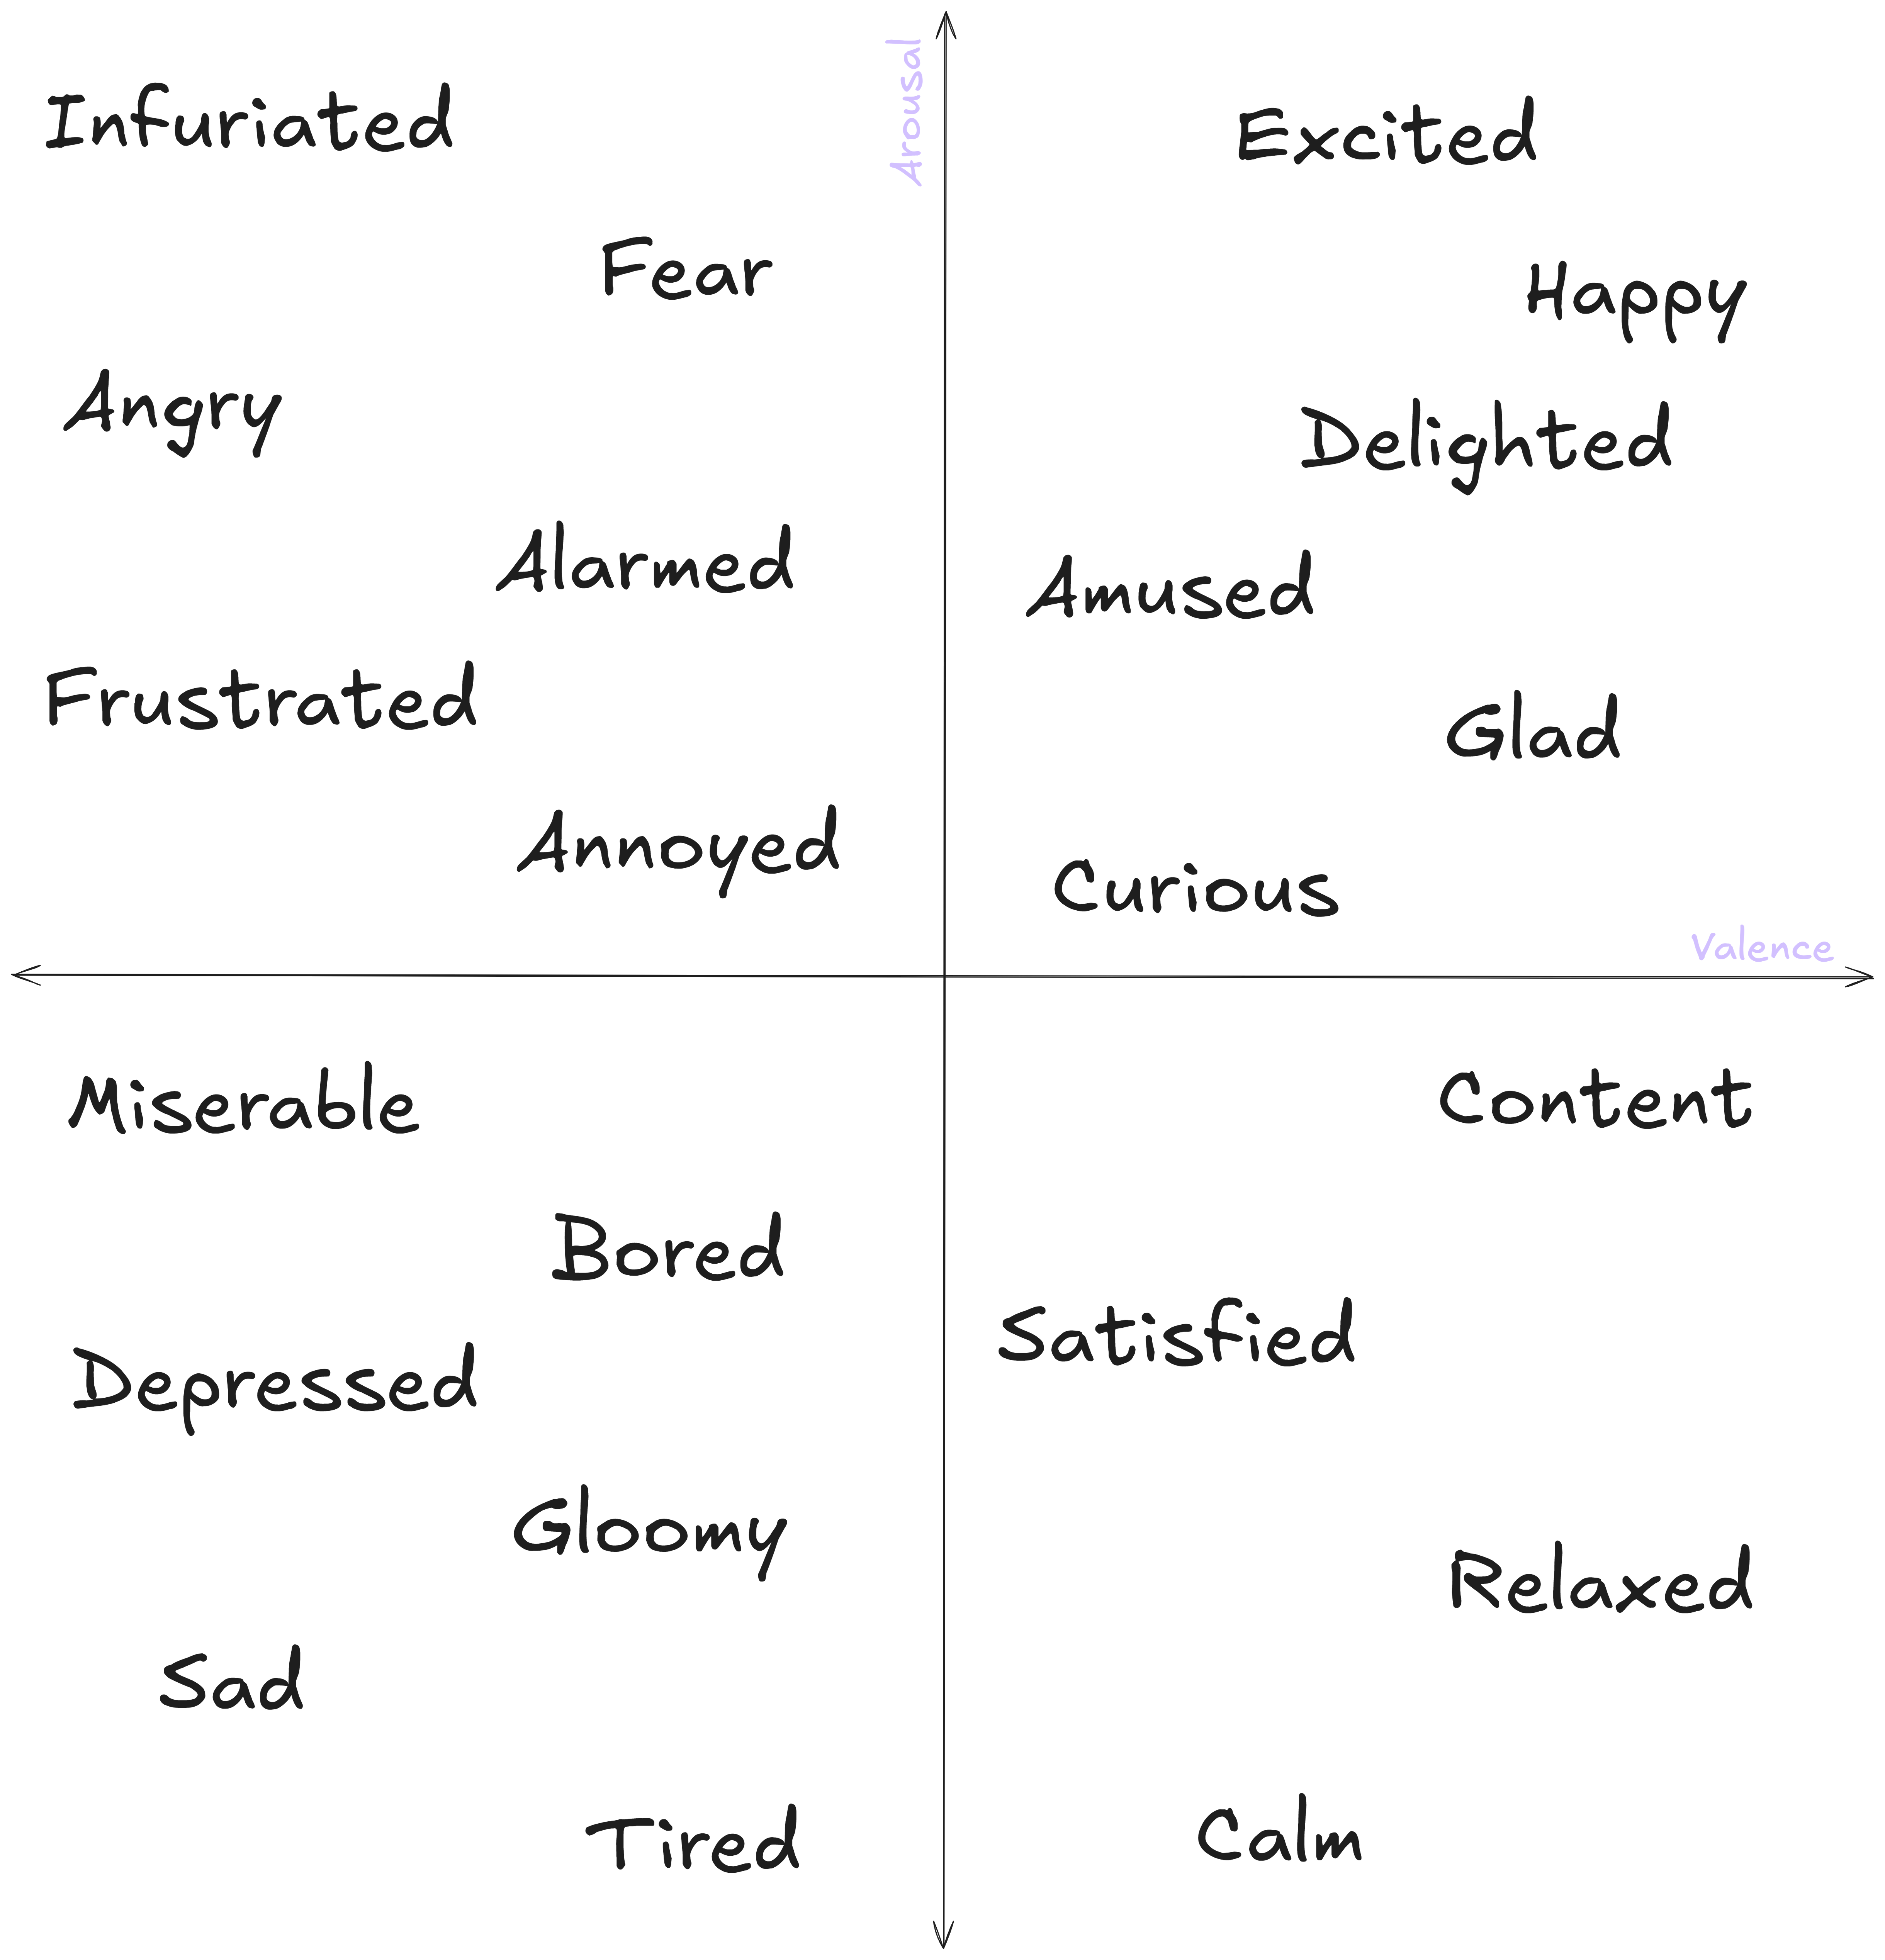


- Listen to your recorded files again - what Valence and Arousal do they represent?
- Label each file by naming them as follows: "Reference_vX.X_aX.X.wav" - Here, the X.X are to be replaced with your valence/arousal labels. For example, a file with valence -0.8 and arousal 0.2 should be called "Reference_v-0.8_a0.2.wav".
- For this we have created a python script, you can use that you can use to verify your valence and arousal values and update the file names. 
- Upload all files into this Google Colab instance - into the directory "ReferenceAudio".

# Show Covered Valence/Arousal Space
Execute this method to visualize which parts of the valence/arousal space you have already covered with your reference audio. Each of your labeled audio samples is represented by a purple dot.

In case there are large areas that are not yet covered, just record additional samples that cover the respective area!

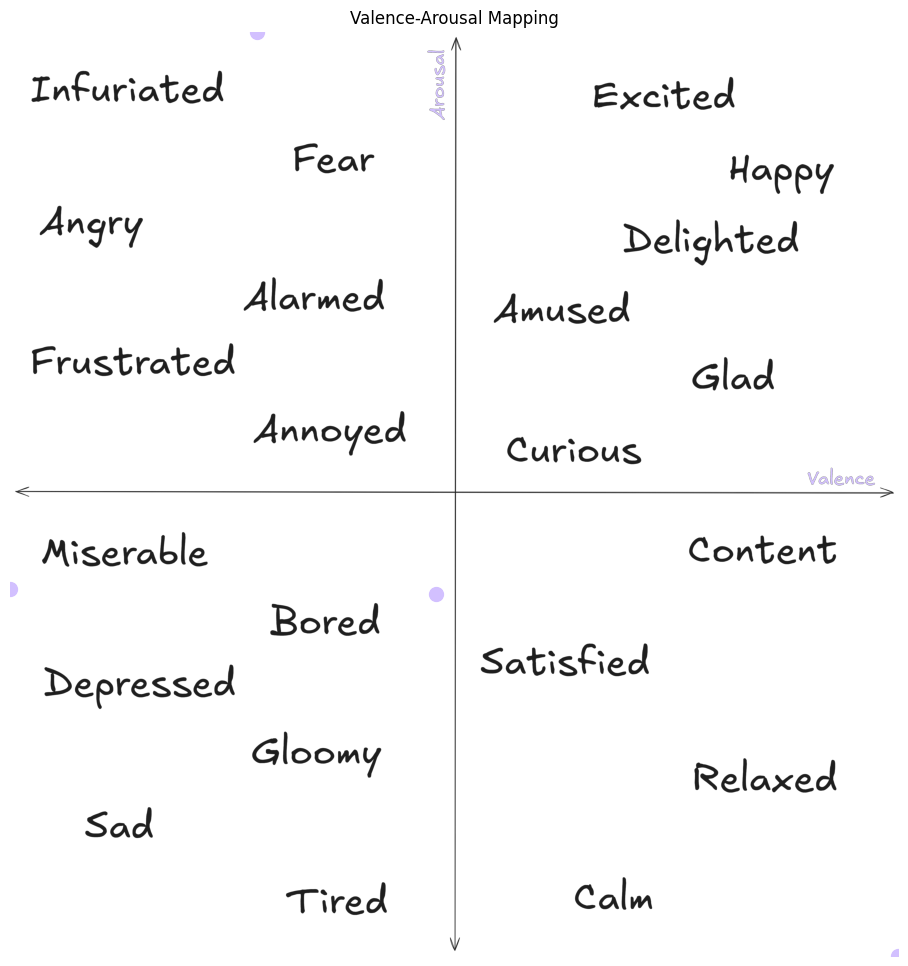

In [7]:
plot_va_points_on_image()

# Synthesize!
Now, try out your own Emotional TTS system! Refine it by uploading new samples until you are happy with the result!

In [8]:
synthesize("This is how I sound when I'm happy!", valence=0.8, arousal=0.8)

Using reference: ReferenceAudio/Reference_v-0.445_a1.000.wav
 > Text splitted to sentences.
["This is how I sound when I'm happy!"]
 > Processing time: 5.195179224014282
 > Real-time factor: 1.6311394737878437
Synthesized speech saved to: /tmp/tmpzqegqud6.wav
